In [1]:
# FOTO Tutorial in https://nbviewer.jupyter.org/urls/framagit.org/benjaminpillot/fototex/-/raw/master/tutorial.ipynb

import os
from fototex.foto import Foto, FotoSector, FotoBatch, FotoSectorBatch
from fototex.foto_tools import degrees_to_cardinal
import numpy as np
from matplotlib import pyplot as plt
from skimage import io
from rasterio.plot import show
import rasterio

In [17]:
# Read image
sample_image = io.imread("C:/Projetos/Vant_Rondonia_Embrapa/09Dez2019/Teste_Kmeans/Area_CobArb/09Dez2019_CHM_CobArb_only.tif")

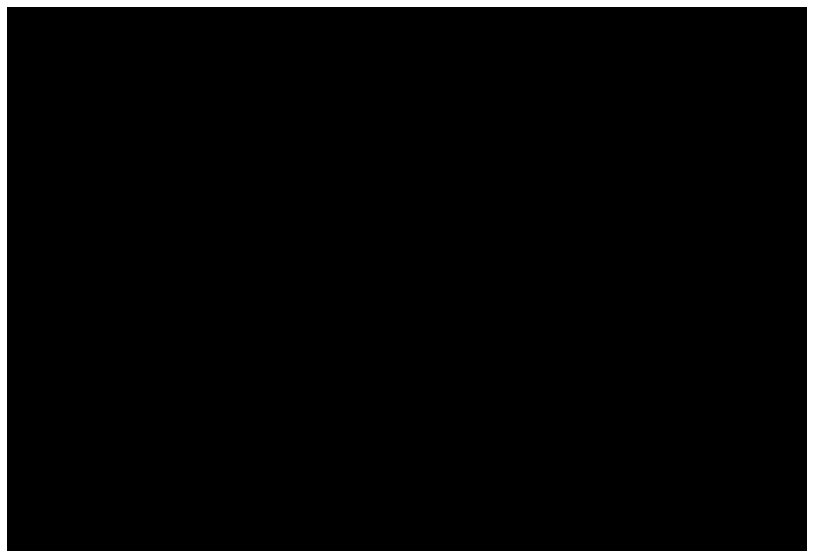

In [18]:
# Plot image
plt.rcParams['figure.figsize'] = [15, 10]
#show(sample_image)
img = plt.imshow(sample_image, cmap='gray', vmin=50, vmax=106)
plt.axis('off')
plt.show()

In [5]:
# Build a simple Foto instance. If raster has more than one band, consider only band 1
foto_obj = Foto("C:/Projetos/Vant_Rondonia_Embrapa/09Dez2019/CHM_Cecropia_semGNSSpreciso_11_06_35_UTM_AOI.tif",
                method="block", band=1, in_memory=True)

In [6]:
# Run FOTO with a window size of 11
foto_obj.run(window_size=11, keep_dc_component=True)

Retrieve isotropic R-spectra: 100%|████████| 963k/963k [01:10<00:00, 13.6kit/s]


In [7]:
# Save and check in QGis. Just Check that the tiff has the same name of the input with FOTO parameters details
foto_obj.save_rgb()

Write RGB output image to 'C:/Projetos/Vant_Rondonia_Embrapa/09Dez2019\CHM_Cecr


In [22]:
# Check FOTO results tiff import

fototiff = rasterio.open("C:/Projetos/Vant_Rondonia_Embrapa/09Dez2019/Teste_Kmeans/Area_CobArb/CHM_CobArb_FOTO_wsize11.tif")
# Mask is necessary to avoid nodata values that harm mathematical operations
ft_read = fototiff.read(1, masked=True)
ft_read.max()

21.432062

In [8]:
# Calculate Lacunarity

# For CHM, it is necessary to convert from float to int and stack three equal bands due to a satsense library bug.
# This process is necessary because such CHM stack will be treated as an RGB layer to calculate Lacunarity

sample_image = rasterio.open("C:/Projetos/Vant_Rondonia_Embrapa/09Dez2019/Teste_Kmeans/CHM_Kmeans_UTM.tif")
chm = sample_image.read(1)*100
chm = chm.astype(int)
print(chm.min())

with rasterio.Env():

    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = sample_image.profile

    # And then change the band count to 1, set the
    # dtype to uint32, and specify LZW compression.
    profile.update(
        nodata=chm.min(),
        dtype=rasterio.int32,
        count=3,
        compress='lzw')

    with rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/09Dez2019/Teste_Kmeans/CHM_int_values.tif', 'w', **profile) as dst:
        dst.write(chm.astype(rasterio.int32), 1)
        dst.write(chm.astype(rasterio.int32), 2)
        dst.write(chm.astype(rasterio.int32), 3)

#sample_image = io.imread("C:/Projetos/Vant_Rondonia_Embrapa/03Dez2019/Teste_Kmeans/CHM_int_values.tif")

-2147483648


C:\Users\Rafael\anaconda3\envs\canopy_evaluation\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in multiply
  import sys


In [9]:
# Lacunarity: tutorial: https://github.com/DynaSlum/satsense/blob/master/notebooks/FeatureExtraction/feature_extraction.ipynb
# The mentioned tutorial uses other features, but here it is Lacunarity

# General imports
import rasterio as rio
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# Satsense imports
from satsense import Image
from satsense.generators import FullGenerator
from satsense.extract import extract_features
from satsense.features import Lacunarity

In [10]:
# Multiple windows
two_windows = [(25, 25), (30, 30)]
# Single window
one_window = [(37, 37),]
features = [
    Lacunarity(two_windows, box_sizes=(10, 20, 23)),
    Lacunarity(one_window),
]

In [11]:
# Import image by satsense package
image = Image('C:/Projetos/Vant_Rondonia_Embrapa/09Dez2019/Teste_Kmeans/CHM_int_values.tif',
              'rgb', band='rgb')# if RGB or if CHM with 3 equal bands to support satsense specifications
              #'monochrome', band=0)# if CHM
image.precompute_normalization()

In [12]:
from satsense.bands import BANDS
print(BANDS['monochrome'])
image.bands

{'pan': 0}


{'red': 0, 'green': 1, 'blue': 2}

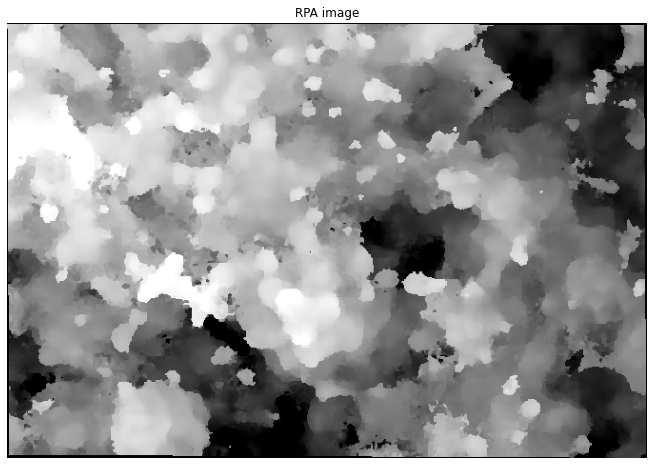

In [13]:
# Plot the imported image
fig, (ax1) = plt.subplots(1, 1, figsize=(24, 8), sharey=True)

ax1.axis('off')
ax1.imshow(image['rgb'])
#ax1.imshow(image['grayscale'])#, cmap="gray")
ax1.set_title('RPA image')

plt.show()

The generator is 46 by 68  blocks


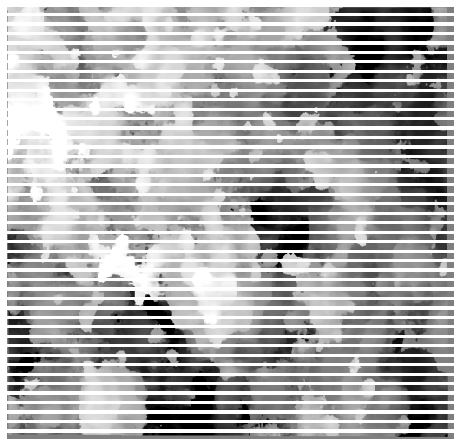

In [14]:
# Create the FullGenerator, which creates patches of the image in steps of 20x20 pixels

step = 10

generator = FullGenerator(image, (step, step))
print("The generator is {} by {}".format(*generator.shape), " blocks")

# Create a gridspec to show the images
gs = gridspec.GridSpec(*generator.shape)
gs.update(wspace=0.05, hspace=0.05)

# Load a baseimage into the generator.
# The window is the same as the block size to show the blocks used
generator.load_image('rgb', ((step, step),))
#generator.load_image('grayscale', ((step, step),))

fig = plt.figure(figsize=(8, 8))
for i, img in enumerate(generator):
    ax = plt.subplot(gs[i])
    ax.imshow(img.filled(0.5))
    ax.axis('off')

In [15]:
# Calculate the feature, which is Lacunarity in this case

'''In this cell we use the extract_features function from satsense to extract all features.

extract_features returns a python generator that we can loop over. Each invocation of this
generator returns the feature vector for one feature in the order of the features list.
The shape of this vector is (x, y, w, v) where

- x is the number of blocks of the generator in the x direction
- y is the number of blocks of the generator in the y direction
- w is the number of windows the feature is calculated on
- v is the length of the feature per window

We use a little numpy reshaping to merge these feature vectors into a single feature vector
of shape (x, y, n) where n is the total length of all features over all windows. In this
example it will be (8, 8, 13) because:

- HoG has 5 numbers per window and 2 windows  :   10
- NirNDVI has 1 number per window and 1 window:    1
- Pantex has 1 number per window and 2 windows:    2
                                         Total:   13'''

vector = []
for feature_vector in extract_features(features, generator):
    # The shape returned is (x, y, w, v)
    # Reshape the resulting vector so it is (x, y, w * v)
    # e.g. flattened along the windows and features
    data = feature_vector.vector.reshape(
                *feature_vector.vector.shape[0:2], -1)
    vector.append(data)
# dstack reshapes the vector into and (x, y, n)
# where n is the total length of all features
featureset = np.dstack(vector)

print("Feature set has shape:", featureset[:, :, 0].shape) # get only one of the features in featureset
print(featureset[:, :, 0][:6])# Head to show only the first six lines

Feature set has shape: (46, 68)
[[0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0. 

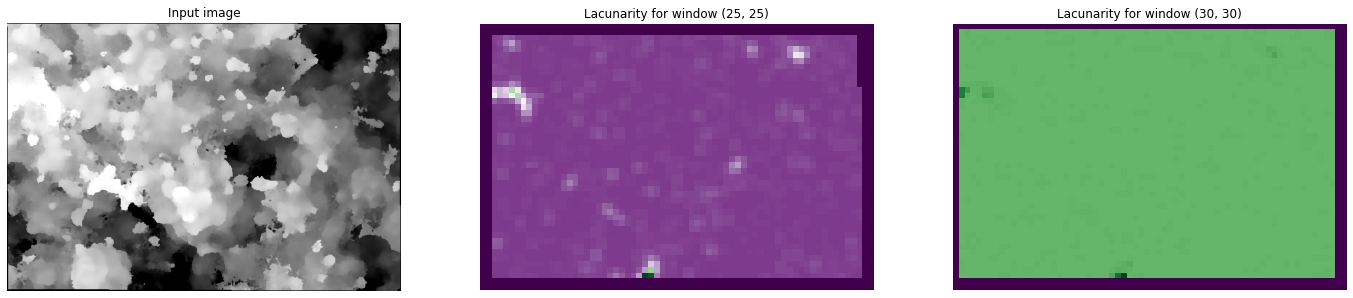

In [16]:
# Plot Lacunarity for two windows

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

ax1.axis('off')
ax1.imshow(image['rgb'])
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(featureset[:, :, 0], cmap="PRGn")
ax2.set_title('Lacunarity for window {}'.format(two_windows[0]))

ax3.axis('off')
ax3.imshow(featureset[:, :, 5], cmap="PRGn")
ax3.set_title('Lacunarity for window {}'.format(two_windows[1]))

plt.show()

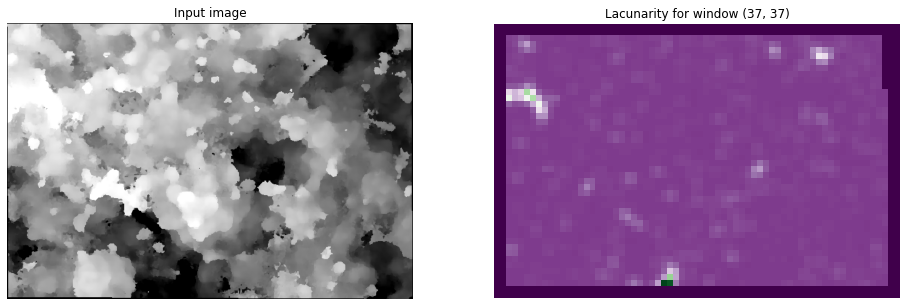

In [17]:
# Plot Lacunarity for one window

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.axis('off')
ax1.imshow(image['rgb'])
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(featureset[:, :, 0], cmap="PRGn")
ax2.set_title('Lacunarity for window {}'.format(one_window[0]))

plt.show()

In [ ]:
# Export Lacunarity results as tiff file

In [18]:
import os
import gdal, ogr, osr
import numpy as np
import fiona as fn
import pandas as pd
import geopandas as gpd
import rasterio as rio
import scipy as sp
import matplotlib.pyplot as plt

In [19]:
# Export Lacunarity results as tiff file

import rasterio
from rasterio.transform import from_origin

dataset2 = rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/09Dez2019/Teste_Kmeans/CHM_int_values.tif')

print(dataset2.crs)
print(dataset2.transform*(dataset2.width, dataset2.height))
print(np.asarray(dataset2.transform*(dataset2.width, dataset2.height))[1])
print(type(dataset2.res))

arr = featureset[:, :, 0].astype(np.float)

# Resolution is multiplied by the lacunarity step to involve the generated windows. Such step is calculated here
# by dividing the original RGB width and height by the lacunarity image width and height
transform = from_origin(dataset2.bounds.left,
                        dataset2.bounds.top,
                        dataset2.res[0]*(dataset2.width/featureset[:, :, 0].shape[1]), 
                        dataset2.res[1]*(dataset2.height/featureset[:, :, 0].shape[0]))

new_dataset = rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/09Dez2019/Teste_Kmeans/Lacunarity.tif',
                            'w', driver='GTiff',
                            height = arr.shape[0], width = arr.shape[1],
                            count=1, dtype=str(arr.dtype),
                            crs='+proj=utm +zone=20 +south +ellps=GRS80 +datum=WGS84 +units=m +no_defs',
                            transform=transform)

new_dataset.write(arr, indexes=1)
new_dataset.close()

EPSG:32720
(303164.76702240115, 8950215.314023769)
8950215.314023769
<class 'tuple'>


In [32]:
# Check some details of the variables to help understading the code
dataset2 = rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/03Dez2019/Teste_Kmeans/RGB_Teste_Kmeans.tif')
lac = rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/03Dez2019/Teste_Kmeans/Lacunarity.tif')
lon = np.asarray(dataset2.transform*(dataset2.width, dataset2.height))[0]
lat = np.asarray(dataset2.transform*(dataset2.width, dataset2.height))[1]
#lon = np.asarray(dataset2.transform*(image.width, dataset2.height))[0]
#lat = np.asarray(dataset2.transform*(image.width, dataset2.height))[1]
print([lon,lat])
print(dataset2.meta)
print(lac.meta)
print(dataset2.height)
print(featureset[:, :, 0].shape[0])
print(dataset2.bounds.left)
print(dataset2.bounds.top)

[297614.9690817031, 8943721.276302818]
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1478, 'height': 995, 'count': 3, 'crs': CRS.from_epsg(32720), 'transform': Affine(0.020840835639180866, 0.0, 297584.1663266284,
       0.0, -0.021063620593932297, 8943742.234605309)}
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 74, 'height': 50, 'count': 1, 'crs': CRS.from_epsg(32720), 'transform': Affine(0.020840835639180866, 0.0, 297614.9690817031,
       0.0, -0.021063620593932297, 8943721.276302818)}
995
50
297584.1663266284
8943742.234605309


In [20]:
# Skewness and Kurtosis filter

import scipy.ndimage as ndimage
import scipy.stats as st
from scipy.ndimage.filters import generic_filter
import numpy as np
import rasterio
from rasterio.transform import from_origin

In [21]:
dataset2 = rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/09Dez2019/Teste_Kmeans/CHM_Kmeans_UTM.tif')

In [22]:
# Convert raster to array
img = dataset2.read(1, masked=True)
#img[img==img.min()] = np.nan
print(img[0])

# Calculate skewness after converting input raster to array
skew = ndimage.generic_filter(img, st.skew, size=10)
print(skew)

[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --

In [23]:
# Convert Skewness array to tiff

transform = from_origin(dataset2.bounds.left,
                        dataset2.bounds.top,
                        dataset2.res[0],
                        dataset2.res[1])

new_dataset = rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/09Dez2019/Teste_Kmeans/Skewness.tif',
                            'w', driver='GTiff',
                            height = skew.shape[0], width = skew.shape[1],
                            count=1, dtype=str(skew.dtype),
                            crs='+proj=utm +zone=20 +south +ellps=GRS80 +datum=WGS84 +units=m +no_defs',
                            transform=transform)

new_dataset.write(skew, indexes=1)
new_dataset.close()

In [24]:
# Calculate kurtosis after converting input raster to array
kurt = ndimage.generic_filter(img, st.kurtosis, size=10)#size=(1,5))
print(kurt)

[[ 0.25        0.25        0.25       ... -1.2380953  -0.51754385
  -0.51754385]
 [ 0.25        0.25        0.25       ... -1.2380953  -0.51754385
  -0.51754385]
 [-0.17249417 -0.17249417 -0.17249417 ... -1.2380953  -0.51754385
  -0.51754385]
 ...
 [-1.2380953  -1.2380953  -1.2380953  ...  0.25        0.25
   0.25      ]
 [-0.51754385 -0.51754385 -0.51754385 ...  0.25        0.25
   0.25      ]
 [-0.51754385 -0.51754385 -0.51754385 ...  0.25        0.25
   0.25      ]]


In [25]:
# Convert Kurtosis array to tiff

transform = from_origin(dataset2.bounds.left,
                        dataset2.bounds.top,
                        dataset2.res[0],
                        dataset2.res[1])

new_dataset = rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/09Dez2019/Teste_Kmeans/Kurtosis.tif',
                            'w', driver='GTiff',
                            height = kurt.shape[0], width = kurt.shape[1],
                            count=1, dtype=str(kurt.dtype),
                            crs='+proj=utm +zone=20 +south +ellps=GRS80 +datum=WGS84 +units=m +no_defs',
                            transform=transform)

new_dataset.write(kurt, indexes=1)
new_dataset.close()

In [26]:
# Calculate Standard Deviation filter

import numpy as np
import rasterio
from scipy.interpolate import griddata
import scipy.ndimage as ndimage
import scipy.stats as st
from scipy.ndimage.filters import generic_filter
from rasterio.transform import from_origin

dataset3 = rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/09Dez2019/Teste_Kmeans/CHM_Kmeans_UTM.tif')
# Convert raster to array
chm = dataset3.read(1)
# Turn minimum values to nan
chm[chm==chm.min()] = np.nan#float(0)

# Calculate standard deviation filter after converting input raster to array
std = generic_filter(chm, np.std, size=10)
print(std)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [27]:
# Convert CHM Standard Deviation array result to tiff

transform = from_origin(dataset3.bounds.left,
                        dataset3.bounds.top,
                        dataset3.res[0],
                        dataset3.res[1])

new_dataset = rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/09Dez2019/Teste_Kmeans/Std_CHM.tif',
                            'w', driver='GTiff',
                            height = std.shape[0], width = std.shape[1],
                            count=1, dtype=str(std.dtype),
                            crs='+proj=utm +zone=20 +south +ellps=GRS80 +datum=WGS84 +units=m +no_defs',
                            transform=transform)

new_dataset.write(std, indexes=1)
new_dataset.close()

In [ ]:
# Find an algorithm that classifies CHM heterogeneity into good, medium or bad Forest Restoration

In [31]:
# Normalize layers' values

import numpy as np
import rasterio
from rasterio.rio import insp

dt1 = rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/03Dez2019/Teste_Kmeans/FOTO_CHM_Kmeans_UTM_block_wsize11.tif')
# Convert raster to array
foto = dt1.read(1, masked=True)
#foto = foto/foto.max()

dt2 = rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/03Dez2019/Teste_Kmeans/Lacunarity.tif')
# Convert raster to array
lac = dt2.read(1)
#lac = lac/lac.max()

dt3 = rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/03Dez2019/Teste_Kmeans/Skewness.tif')
# Convert raster to array
skw = dt3.read(1)
#skw = skw/skw.max()

dt4 = rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/03Dez2019/Teste_Kmeans/Kurtosis.tif')
# Convert raster to array
kurt = dt4.read(1)
#kurt = kurt/kurt.max()

dt5 = rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/03Dez2019/Teste_Kmeans/Std_CHM.tif')
# Convert raster to array
std_chm = dt5.read(1, masked=True)
std_chm = std_chm/std_chm.max()

std_chm.max()

masked

In [32]:
print("FOTO min, mean and max: ", foto.min(), foto.mean(), foto.max())
print("Lacunarity min, mean and max: ", lac.min(), lac.mean(), lac.max())
print("Skewness min, mean and max: ", skw.min(), skw.mean(), skw.max())
print("Kurtosis min, mean and max: ", kurt.min(), kurt.mean(), kurt.max())

FOTO min, mean and max:  -0.6233128 2.0243832918739635e-08 24.517122
Lacunarity min, mean and max:  0.0 1.9373362516085306 441.0
Skewness min, mean and max:  -9.849371 -0.029224548 9.849371
Kurtosis min, mean and max:  -3.0 2.389238 95.0101


In [9]:
# Calculate PCA

import skimage, rasterio, numpy, os, sklearn
from rasterio.plot import reshape_as_raster, reshape_as_image
from sklearn.decomposition import pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

C:\Users\Rafael\anaconda3\envs\canopy_evaluation\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.decomposition.pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [23]:
infile = r"C:/Projetos/Vant_Rondonia_Embrapa/09Dez2019/Teste_Kmeans/Area_CobArb/CHM_CobArb_FOTO_wsize11.tif"
im = rasterio.open(infile)
arr1 = im.read()
arr1.shape
arr = numpy.reshape(arr1, (3, arr1.shape[1]*arr1.shape[2]))
arr.shape

# Below is for calculating PCA as array

#standardizedData = StandardScaler().fit_transform(arr.data)

#pca = PCA(n_components=2)

#principalComponents = pca.fit_transform(X = standardizedData)

# to get how much variance was retained
#print(pca.explained_variance_ratio_.sum())

#print(principalComponents.shape)

(3, 2604)

In [24]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import io
from mpl_toolkits.mplot3d import Axes3D

In [25]:
C = np.cov(arr)
D,V = linalg.eig(C)
D   = D.real
print(np.shape(D))
print(np.shape(V))
print(arr.shape)
print(V[0,0])

(3,)
(3, 3)
(3, 2604)
0.5773573874978624


(3,)
(3,)


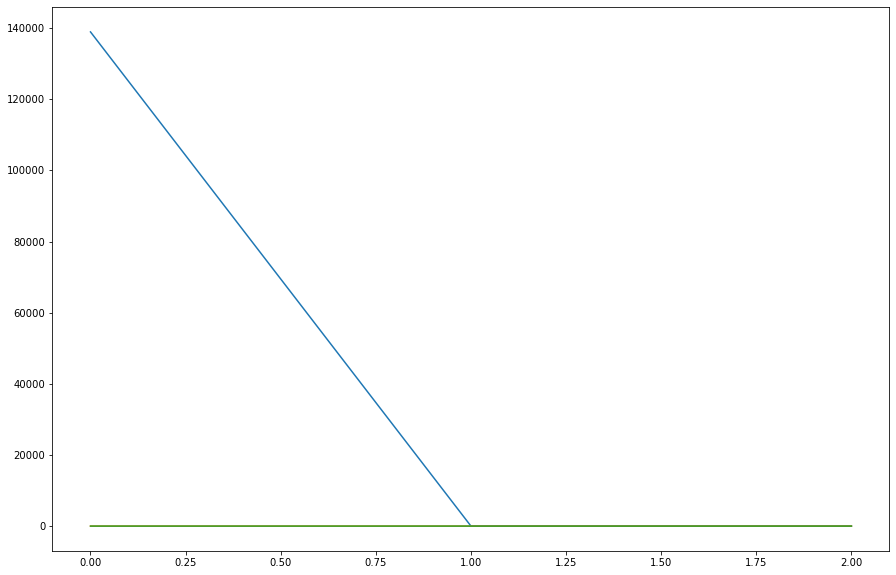

In [26]:
plt.figure(10)
print(D.shape)
DiagD = np.diag(D)
print(D.shape)
plt.plot(DiagD)
#Exercise
#plt.plot(D[range(10)])
#plt.plot(D[range(10, 30, 10)])
plt.show()

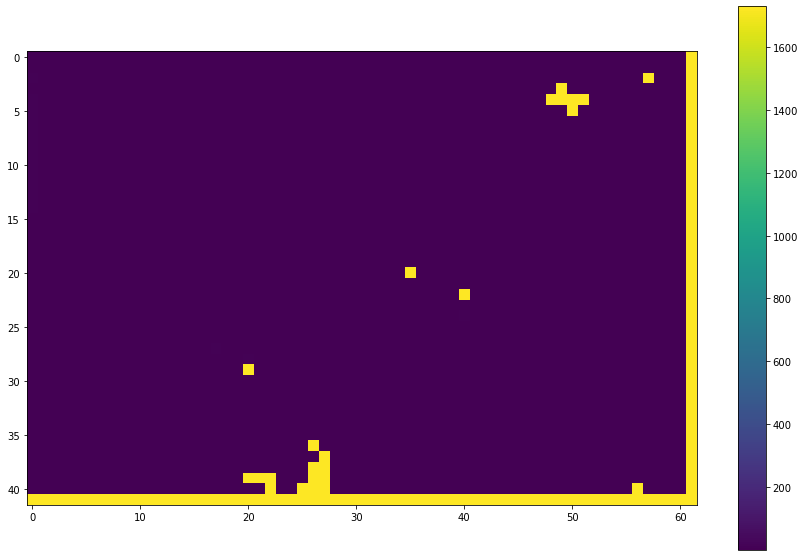

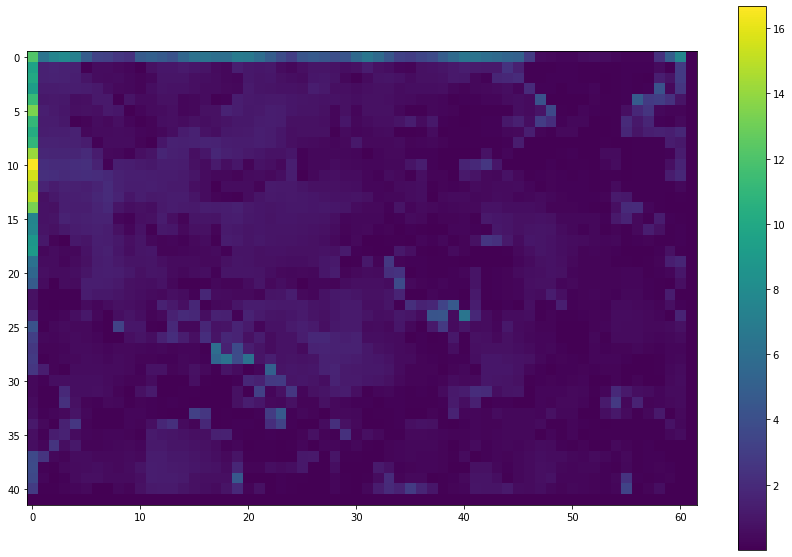

In [28]:
from rasterio.transform import from_origin

arrPCA = np.dot(V.T, arr)

for coord in range(2):# Choose how many PCAs you want inside range()
    P1 = arrPCA[coord, :]
    PCAIm      = np.reshape(P1, (arr1.shape[1], arr1.shape[2]), order='C')
    plt.figure(14+coord)
    plt.imshow(np.abs(PCAIm))
    plt.colorbar()
    plt.show()
        

    transform = from_origin(im.bounds.left,
                        im.bounds.top,
                        im.res[0],
                        im.res[1])

    new_dataset = rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/09Dez2019/Teste_Kmeans/Area_CobArb/FOTO_PCA_'+str(coord+1)+'.tif',
                            'w', driver='GTiff',
                            height = arr1.shape[1], width = arr1.shape[2],
                            count=1, dtype=str(arr1.dtype),# nodata=PCAIm.min(),# if you wish to set PCA1 border as nodata
                            crs=im.crs,#'+proj=utm +zone=20 +south +ellps=GRS80 +datum=WGS84 +units=m +no_defs',
                            transform=transform)

    new_dataset.write(PCAIm.astype(str(arr1.dtype)), indexes=1)
    new_dataset.close()



In [ ]:
# Daqui pra baixo valem os registros

In [6]:
# Teste interpolar nan para obter o valor mínimo de uma copa

import numpy as np
from scipy.interpolate import griddata

dataset3 = rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/03Dez2019/Teste_Kmeans/CHM_Kmeans_UTM.tif')
# Convert raster to array
chm = dataset3.read(1)
# Turn minimum values to nan
chm[chm==chm.min()] = np.nan
chm

# Teste de interpolação
x, y = np.indices(chm.shape)
interp = np.array(chm)
interp[np.isnan(interp)] = griddata(
     (x[~np.isnan(chm)], y[~np.isnan(chm)]), # points we know
     chm[~np.isnan(chm)],                    # values we know
     (x[np.isnan(chm)], y[np.isnan(chm)]))   # points to interpolate
interp

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [31]:
# Trying a faster processing for Standard Deviation filter

from scipy.ndimage.filters import uniform_filter

dataset3 = rasterio.open('C:/Projetos/Vant_Rondonia_Embrapa/03Dez2019/Teste_Kmeans/CHM_Kmeans_UTM.tif')
# Convert raster to array
chm = dataset3.read()

def window_stdev(X, window_size):
    #r,c = X.shape
    #X+=np.random.rand(r,c)*1e-6
    c1 = uniform_filter(X, window_size, mode='reflect')
    c2 = uniform_filter(X*X, window_size, mode='reflect')
    return np.sqrt(c2 - c1*c1)

std = window_stdev(chm, 20)
print(std)
print(std.shape[1])

[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
500


C:\Users\Rafael\anaconda3\envs\canopy_evaluation\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in multiply
  del sys.path[0]
C:\Users\Rafael\anaconda3\envs\canopy_evaluation\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in multiply
  
C:\Users\Rafael\anaconda3\envs\canopy_evaluation\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in subtract
  
